In [1]:
import sys
sys.executable

'/mnt/vol_b/miniconda3/envs/fpnsemseg/bin/python'

In [2]:
!nvidia-smi

Sun Apr 23 11:29:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:00:05.0 Off |                  N/A |
|  0%   42C    P2   127W / 350W |   8316MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:00:06.0 Off |                  N/A |
|  0%   

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVIES"] = "0"
device = "cuda"

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

import numpy as np
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [133]:
class UnsupervisedDataset(Dataset):
    def __init__(self, transform1, transform2, root_dir: str = "../data/unlabeled"):
        super().__init__()
        self.root_dir = root_dir
        self.paths = [os.path.join(self.root_dir, p) for p in os.listdir(self.root_dir)]
        self.transform1 = transform1
        self.transform2 = transform2
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        imgp = self.paths[idx]
        img1 = Image.open(imgp)
        img2 = img1.copy()
        
        img1, img2 = np.array(img1)[:, :, :3], np.array(img2)[:, :, :3]
        
        img1 = self.transform1(image=img1)["image"]
        img2 = self.transform2(image=img2)["image"]
        
        return img1, img2

In [132]:
class Projector(nn.Module):
    
    def __init__(self,
                 in_dim: int,
                 h_dim: int = 2048,
                 out_dim: int = 2048
    ) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(*[
            nn.Linear(in_dim, h_dim), 
            nn.BatchNorm1d(h_dim), 
            nn.ReLU(inplace=True),
        ])
        
        self.layer2 = nn.Sequential(*[
            nn.Linear(h_dim, h_dim), 
            nn.BatchNorm1d(h_dim), 
            nn.ReLU(inplace=True),
        ])
        
        self.layer3 = nn.Sequential(*[
            nn.Linear(h_dim, out_dim), 
            nn.BatchNorm1d(out_dim), 
        ])
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

In [46]:
class Predictor(nn.Module):
    
    def __init__(self,
                 in_dim: int = 2048,
                 h_dim: int = 2048,
                 out_dim: int = 2048
    ) -> None:
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Linear(h_dim, out_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        return x

In [47]:
class D(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, z):
        return -F.cosine_similarity(p, z.detach(), dim=-1).mean()

In [74]:
class Model(nn.Module):
    
    def __init__(self, out_dim: int = 2048):
        super().__init__()
        encoder = torchvision.models.resnet34(weights=None)
        
        self.encoder = nn.Sequential(*list(encoder.children())[:-1])
        self.projector = Projector(encoder.fc.in_features)
        self.predictor = Predictor()
        
        self.D = D()
        
    def forward(self, x1, x2):
        e1, e2 = self.encoder(x1).squeeze(), self.encoder(x2).squeeze()
        
        z1 = self.projector(e1)
        z2 = self.projector(e2)
        
        p1, p2 = self.predictor(z1), self.predictor(z2)
            
        return 0.5 * self.D(p1, z2) + 0.5 * self.D(p2, z1)

In [75]:
m = Model()
m

Model(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [77]:
x1 = torch.randn((2, 3, 224, 224))
x2 = torch.randn_like(x1)

loss = m(x1, x2)
loss.backward()

In [150]:
BS: int = 512
NUM_EPOCHS: int = 100
BASE_LR: float = 0.05

config = {
    "lr": BASE_LR * (BS / 256), 
    "momentum": 0.9, 
    "wd": 0.0001, 
}

In [143]:
class Module(pl.LightningModule):    
    def __init__(self, config):
        super().__init__()
        self.cfg = config
        self.pretrainer = Model()
        
        self.tr = A.Compose([
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5), 
            A.ShiftScaleRotate(),
            A.RandomBrightnessContrast(p=0.2),
            A.Blur(), 
            A.GaussNoise(), 
            A.ElasticTransform(), 
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
            ToTensorV2()
        ])
    
    def training_step(self, batch, batch_idx):
        img1, img2 = batch
        loss = self.pretrainer(img1, img2)
        self.log("loss", on_step=True, on_epoch=True, progress_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        opt = torch.optim.SGD(
            self.cfg["lr"],
            momentum=self.cfg["momentum"],
            weight_decay=self.cfg["wd"]
        )
        
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, 
            T_max=NUM_EPOCHS
        )
        
        return [opt], [sch]
    
    def train_dataloader(self):
        ud = UnsupervisedDataset(
            transform1 = self.tr, 
            transform2 = self.tr, 
        )
        
        return torch.utils.data.DataLoader(
            ud, 
            pin_memory=True, 
            num_workers=4, 
            batch_size=512, 
            shuffle=True
        )

In [86]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [140]:
tr = A.Compose([
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5), 
    
#     A.InvertImg(),
    
    A.ShiftScaleRotate(),
#     A.RGBShift(),
    
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(), 
    A.GaussNoise(), 
    A.ElasticTransform(), 
    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

vis_tr = A.Compose([
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5), 
    
#     A.InvertImg(),
    
    A.ShiftScaleRotate(),
#     A.RGBShift(),
    
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(), 
    A.GaussNoise(), 
    A.ElasticTransform(), 
])

In [141]:
vis_ud = UnsupervisedDataset(
    transform1 = vis_tr, 
    transform2 = vis_tr, 
)

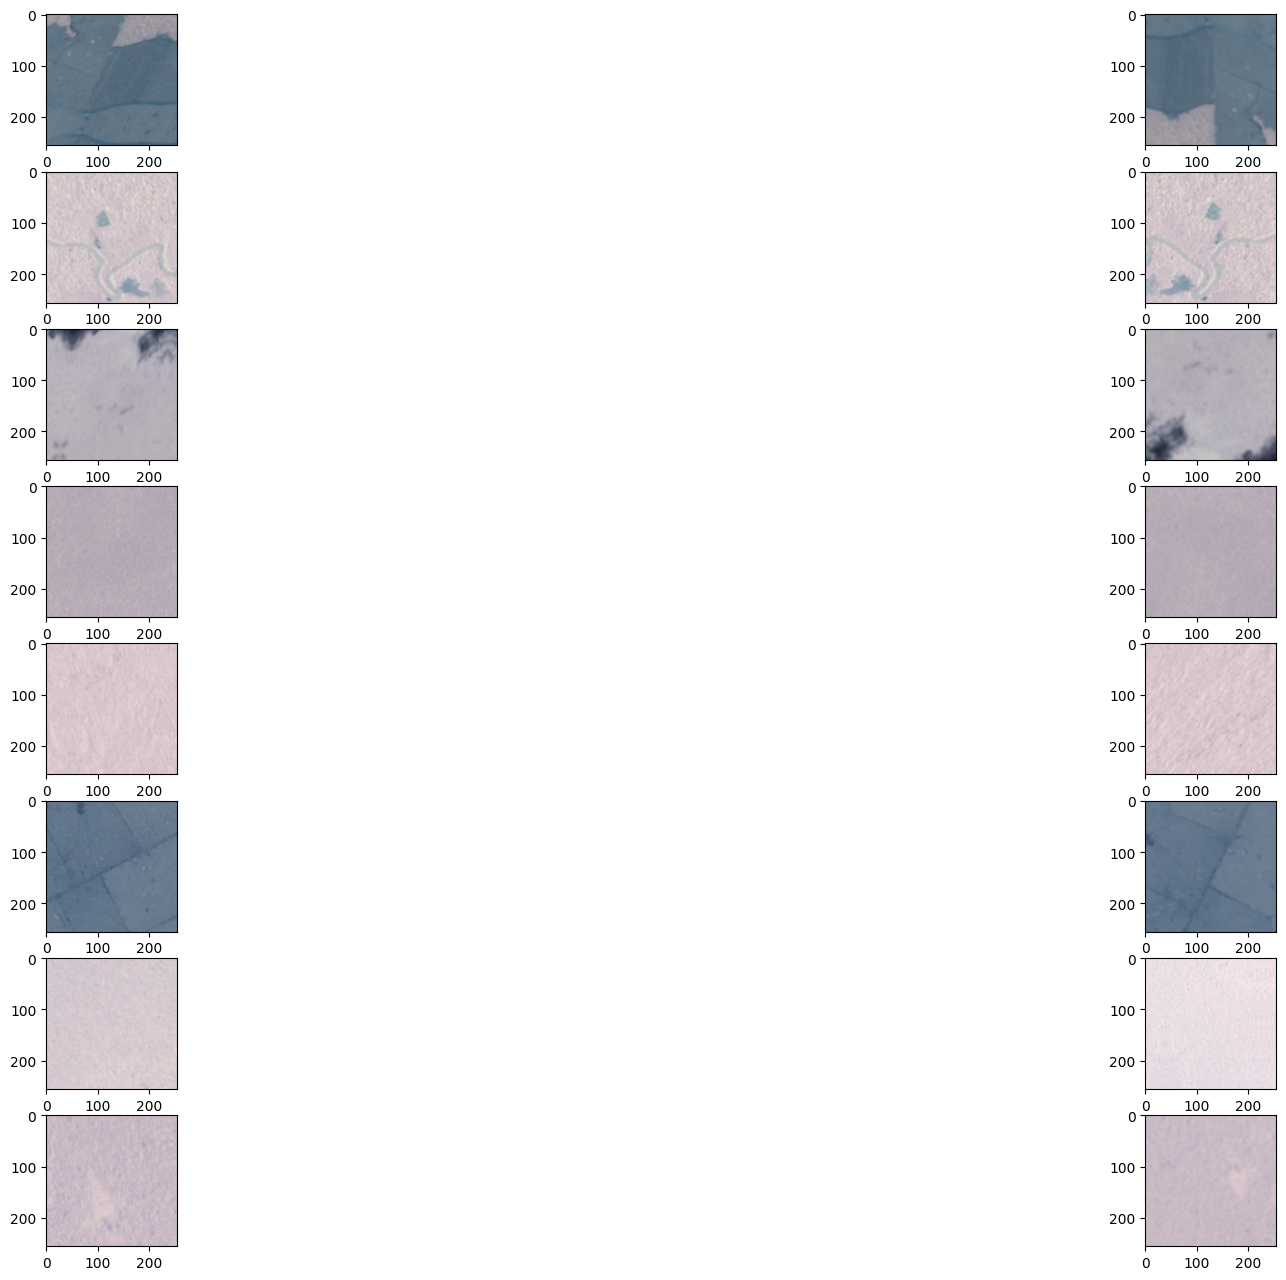

In [142]:
import random

fig, ax = plt.subplots(8, 2, figsize=(26, 16))
ax = ax.flatten()
for i in range(8):
    idx = random.randint(0, len(vis_ud))
    img1, img2 = vis_ud[idx]
    
    ax[2*i].imshow(img1)
    ax[2*i + 1].imshow(img2)
    

In [151]:
model = Module(config)

In [159]:
trainer = pl.Trainer(
    fast_dev_run=True, 
    max_epochs=100,
    accelerator="gpu", 
    strategy="dp",
    callbacks=[
        pl.callbacks.ModelCheckpoint(dirpath = 'unsupervised_checkpoints', monitor = 'loss'), 
#         pl.callbacks.EarlyStopping(monitor="val_loss", mode="min"), 
        pl.callbacks.LearningRateMonitor(), 
    ], 
    logger = pl.loggers.TensorBoardLogger(
        save_dir="unsupervised",
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
